# Teaching a Machine How To Add




### Context

The goal for this notebook is to find whether we can train our machine how to add without explicitly telling it what addition is or how we are getting the result. It should be noted that behind the scenes, the computer is doing a fair bit of calculus, just to learn how to add. This might be silly but nonetheless, it should be interesting.

### The Plan


The plan for our training is as follows:

* Make an **n** X 2 dataframe and fill it with random integers going from 0 to **m**.
* Add another column that will have the sum of the previous two columns. This will be our results column.
* Make an NN (Neural Network) and train it on test data.
* Use the NN model and make it predict the test data.
* Plot a graph with the predictions and actual outcomes to see how well the model works.


And at the end, we can give it two numbers and check what it thinks the sum should be.

### Imports

Let's begin by importing some libraries.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Make the Data

We will declare **n** and **m** as integers where **n** is the number of data we will have and **m** is the maximum number that a random number can be.

In [2]:
n = 100000
m = 1000
df = pd.DataFrame(np.random.randint(0,m,size=(n, 2)), columns=['first', 'second'])
df['sum'] = df['first']+df['second']

In [3]:
df.head()

,first,second,sum
0,925,803,1728
1,886,232,1118
2,212,458,670
3,548,469,1017
4,482,357,839


### Exploratory Data Analysis (EDA)

This is just to see if we can see any correlation between the sum and the inputs that the computer can look for.

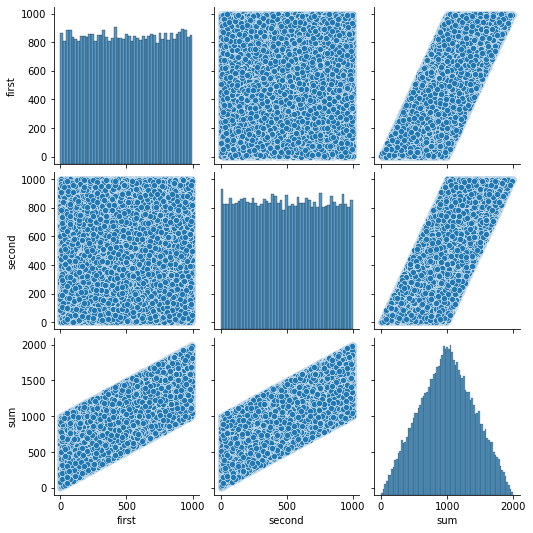

In [4]:
sns.pairplot(data=df)

From the graphs, we can see that the actual sum is positively correlated with both the first and second. This makes sense as the bigger the first or the second number is, the bigger their sum should be. The quadrilateral shape for the actual sum should be due to the range of the first and second number and the box shape seen for first and second is because of the uniform distribution from the random number generator (RNG).

### Model Selection

Now, we will split the dataset into two sets: one for training and the other for testing. Later on, we will use this to see how good our model performs.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['sum'], axis=1), df['sum'], test_size=0.33, random_state=42)

### Training Time

Here, we will set the neural network and train the data on the training set. We will be using tensorflow for this. Dense here is a layer of neurons with the parameter being the number of neurons in that layer. For our loss function, we will be using mean square error to check how close the prediction is to the actual sum and for our optimiser, let's use rmsprop (since I have had more success with this than adam and SGD).

Note: I did some trial and error with the parameters and funnily enough, I have had the most success with 1 neuron per layer. Sometimes I guess, less is more.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [8]:
model = Sequential()
model.add(Dense(1, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')

# Now, when let's start training.

model.fit(x=X_train, y=y_train, epochs=10, verbose=1)

# Due to the randomness of training, if you are getting high loss values, rerun the code until you get lucky.

Epoch 1/10
2094/2094 [==============================] - 1s 572us/step - loss: 383113.4375
Epoch 2/10
2094/2094 [==============================] - 1s 564us/step - loss: 2.3028
Epoch 3/10
2094/2094 [==============================] - 1s 548us/step - loss: 1.6453
Epoch 4/10
2094/2094 [==============================] - 1s 547us/step - loss: 1.4816
Epoch 5/10
2094/2094 [==============================] - 1s 564us/step - loss: 1.4363
Epoch 6/10
2094/2094 [==============================] - 1s 546us/step - loss: 1.4131
Epoch 7/10
2094/2094 [==============================] - 1s 555us/step - loss: 1.4267
Epoch 8/10
2094/2094 [==============================] - 1s 550us/step - loss: 1.4106
Epoch 9/10
2094/2094 [==============================] - 1s 548us/step - loss: 1.4230
Epoch 10/10
2094/2094 [==============================] - 1s 551us/step - loss: 1.4166


Let's graph our decrease in loss to see how quickly the machine learned how to add.

<AxesSubplot:>

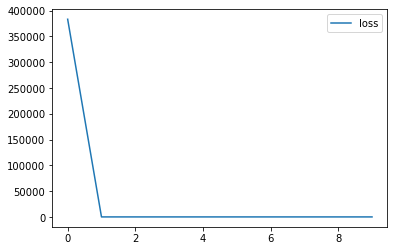

In [9]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

We can see that the cost function flat lines around the 2nd epoch. This is good because if we look at the loss values, we can see that the loss is still going down, albeit slowly. So, if we wanted to, we could have kept going on with more epochs. 

### Evaluation

Now that our model is trained, let's test the test data and see how accurate it predicts the sums.

In [10]:
test_predictions = model.predict(X_test)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
mean_absolute_error(y_test, test_predictions)

0.61499445736047

In [13]:
mean_squared_error(y_test, test_predictions)

0.4454328927432603

The mean absolute error tells us that the predicted sum is on average this value away from the actual value and the mean squared error is just the square of the errors divided by total number of items.

### Testing

In [14]:
#Let's do 420 + 3

model.predict(pd.DataFrame({'first':[420],'second':[3]}))

array([[423.34763]], dtype=float32)

The predicted sum we are getting is to 5 decimal places. This is doing injustice to our metrics calculations since we are only dealing with integers. To counter this, we should round the values so that we can see the real accuracy of our model.

In [15]:
pred_array = [test_predictions[i][0] for i in range(len(test_predictions))]

In [16]:
pred_rounded = pd.Series(pred_array)
pred_rounded = pred_rounded.apply(round)
pred_rounded.head()

0     999
1     875
2     497
3    1224
4    1093
dtype: int64

In [17]:
y_test.head()

75721     999
80184     874
19864     497
76699    1223
92991    1092
Name: sum, dtype: int32

The head values match up. This means our model does well. Let's now recalculate the errors.

In [18]:
mean_absolute_error(y_test, pred_rounded)

0.6443636363636364

In [19]:
mean_squared_error(y_test, pred_rounded)

0.6443636363636364

This is interesting. Both of these values are the same. The only this can happen is if both the error and error squared are the same. The only number that follows this behaviour is 1. So, our calculator is pretty accurate in that regard knowing that it's only off by one. Let's test this hypothesis.

Note: I got the same values on my try. Yours might be different if you reran the code due to the randomness of the training.

### Mistakes

In [20]:
mistakes = []
for i in range(len(y_test)):
    if (y_test.iloc[i] != pred_rounded.iloc[i]):
        mistakes.append(i)

Let's check the first mistake and their values.

In [21]:
mistakes[0]

1

In [22]:
print(f"Actual: {y_test.iloc[7]}. Predicted: {pred_rounded.iloc[7]}")

Actual: 1044. Predicted: 1045


This looks like our hypothesis was right. I have tested out the other mistakes. Feel free to find the other index values and put them in the iloc.

**For our final evaluation, let's check its accuracy.**

In [23]:
print(f"Accuracy: {round(100*(1-len(mistakes)/len(y_test)),2)} %")

Accuracy: 35.56 %


### Conclusion

This is honestly not bad, keeping in mind that the rest of the errors that it did have was only off by 1. Can a machine be taught how to add? Yes. Going beyond, the model might be made better with more epochs or by increasing the training dataset. In conclusion, this experiment was a success.

In [24]:
# Since we trained our data for what happens when we input numbers bigger than m. Let's do 4325 + 3456 = 7781

model.predict(pd.DataFrame({'first':[4325],'second':[3456]}))

array([[7785.883]], dtype=float32)

The result being eerily close intrigues me. The last time I did this, the result was far off. Maybe this time after playing out with the network parameters, the loss is now so low that it can forecast values beyond its training values.

Due to the random nature of the training, I will save my model here. Feel free to play with parameters and the code to see if you can get a lower loss value than mine. Good luck!

In [25]:
from tensorflow.keras.models import load_model

In [26]:
model.save('NN_Addition_100000_1000_10_1_1.h5')